In [41]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)
from rna_learn.load import load_mrna_model, load_dataset
from rna_learn.model import conv1d_regression_model, compile_regression_model

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
alphabet = ['A', 'T', 'G', 'C']
classes = ['psychrophilic', 'mesophilic', 'thermophilic']

In [4]:
run_id = 'run_5vu8k'
model_path = os.path.join(os.getcwd(), f'saved_models_regression/{run_id}/model.h5')
hyperparameters_path = os.path.join(os.getcwd(), f'saved_models_regression/{run_id}/metadata.json')
test_set_path = os.path.join(os.getcwd(), 'data/dataset_test.csv')

In [5]:
with open(hyperparameters_path) as f:
    metadata = json.load(f)
    
metadata

{'run_id': 'run_5vu8k',
 'alphabet': ['A', 'T', 'G', 'C'],
 'classes': ['psychrophilic', 'mesophilic', 'thermophilic'],
 'n_epochs': 41,
 'n_conv_1': 3,
 'n_filters_1': 88,
 'kernel_size_1': 29,
 'n_conv_2': 1,
 'n_filters_2': 54,
 'kernel_size_2': 44,
 'l2_reg': 0.0001,
 'dropout': 0.5,
 'val_loss': 1.00002932969929,
 'val_mae': 12.764189720153809}

In [6]:
model = conv1d_regression_model(
    alphabet_size=len(alphabet), 
    n_conv_1=metadata['n_conv_1'],
    n_filters_1=metadata['n_filters_1'], 
    kernel_size_1=metadata['kernel_size_1'],
    n_conv_2=metadata['n_conv_2'],
    n_filters_2=metadata['n_filters_2'], 
    kernel_size_2=metadata['kernel_size_2'],
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
)
compile_regression_model(model, learning_rate=1e-4)
model.load_weights(model_path)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 4)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 88)          10296     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 88)          224664    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 88)          224664    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 54)          209142    
_________________________________________________________________
global_average_pooling1d (Gl (None, 54)                0         
_________________________________________________________________
dropout (Dropout)            (None, 54)                0     

In [7]:
dataset_df = load_dataset(test_set_path, alphabet)
dataset_df.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence,gc_content,ag_content,gt_content,secondary_structure,paired_nucleotides
0,Micropolyspora internatus,NC_013159.1,rnpB,742238,742645,407,+,45.0,thermophilic,CGAGTTGGCAGGGCGGCCGCGGCCGAGGGCATCGTCTCGACGTCTT...,0.685504,0.562654,0.508600,((((((((((((((..((.(((((((((((.(((...))).)))))...,0.707617
1,Listonella anguillarum,NC_015633.1,recA,2753532,2754579,1047,-,20.0,psychrophilic,ATGGACGAAAATAAGCAGAAGGCGCTAGCCGCAGCACTGGGTCAAA...,0.442216,0.540592,0.510029,....................(((....)))(((((..(((((((((...,0.617001
2,Comamonas badia,NZ_AXVM01000006.1,rpsR,29593,29878,285,-,28.0,mesophilic,TTGACCATGTTCAGGAAATTCAACAAGAATGGCAAGAACGGCAAGC...,0.568421,0.494737,0.414035,(((.((..((((..(..((((.....))))..)..)))))))))((...,0.610526
3,Acetobacter orientalis,NZ_BAMX01000009.1,tsaD,11584,12799,1215,-,30.0,mesophilic,ATGGCGGTCAGCAGCCAGTTTTCAGGCTTACCCGGCACCCCTCACA...,0.596708,0.469959,0.476543,.(((.((((...((((........)))).....(((.............,0.627160
4,Alicyclobacillus kakegawensis,NZ_BCRP01000001.1,tsaD,64880,65918,1038,-,50.0,thermophilic,TTGCTCCTGTTGGGCATTGAGACGAGTTGCGACGAGACCGCCGCGG...,0.680154,0.516378,0.564547,......((((.(((((.((...((....((((((.(((((.(((((...,0.697495


In [8]:
y, dataset_df = make_dataset_balanced(
    dataset_df,
    cat_name='temperature_range',
    output_col='temperature', 
    classes=classes, 
)
y = y.astype(np.float64)

sequences = dataset_df['sequence'].values
x = sequence_embedding(sequences, alphabet)

In [9]:
mean, std = np.mean(y), np.std(y)
y_norm = normalize(y, mean, std)

## Evaluate model

In [10]:
%%time
model.evaluate(x, y_norm, verbose=0)

CPU times: user 6min 39s, sys: 2.58 s, total: 6min 42s
Wall time: 1min 4s


1.1620243263257908

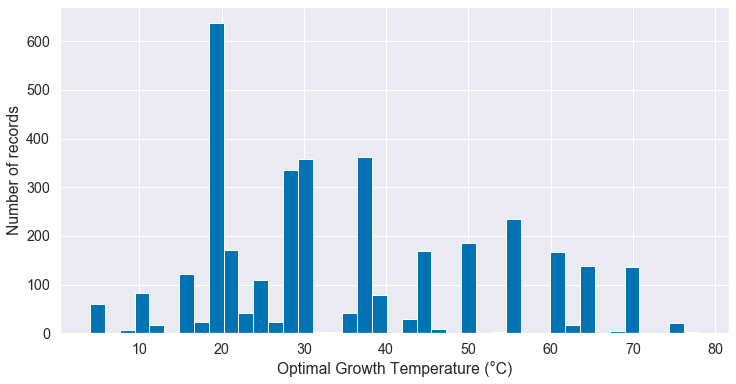

In [11]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(y, bins=len(np.unique(y)));
ax.set_xlabel('Optimal Growth Temperature (°C)');
ax.set_ylabel('Number of records');

In [12]:
%%time
y_hat = model(x)

CPU times: user 7min 13s, sys: 38.5 s, total: 7min 52s
Wall time: 1min 21s


In [13]:
y_mean = denormalize(y_hat.mean().numpy(), mean, std)
y_std = denormalize(y_hat.stddev().numpy(), mean, std)
y_mean.shape

(3591, 1)

In [70]:
mae = np.mean(np.abs(y_mean - y))
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 17.00


In [68]:
rmse = np.sqrt(np.mean((y_mean - y) **2))
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 21.85


## AG content model

In [85]:
def plot_average_data_per_temperature_point(dataset_df, column, figsize=(12, 6)):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    x = dataset_df['temperature'].values
    y = dataset_df[column].values
    
    t_min, t_max = int(np.floor(np.min(x))), int(np.ceil(np.max(x)))
    
    x_bins = np.array(list(range(t_min, t_max + 1)))
    
    y_bins_dict = {t: [] for t in x_bins}
    for i, t in enumerate(x):
        x_bin = int(round(t))
        y_v = y[i]
        
        y_bins_dict[x_bin].append(y_v)
        
    y_bins = np.array([
        np.mean(y_bins_dict[x_bin]) 
        for x_bin in x_bins
        if x_bin in y_bins_dict and len(y_bins_dict[x_bin]) > 0
    ])
    x_bins = np.array([x_bin for x_bin in x_bins if x_bin in y_bins_dict and len(y_bins_dict[x_bin]) > 0])
    
    palette = sns.color_palette()
    
    ax.plot(x, y, 'o', color=palette[0], alpha=0.1, label='Actual')
    ax.plot(x_bins, y_bins, 'o', color=palette[1], label='Average')
    
    X_bins = sm.add_constant(x_bins[:,np.newaxis])
    model = sm.OLS(y_bins, X_bins)

    results = model.fit()

    p_value = results.f_pvalue

    a = results.params[1]
    b = results.params[0]
    y_fit = a * x_bins + b

    if p_value >= 1e-2:
        label = f'Fitted (p = {p_value:.2f})'
    else:
        label = f'Fitted (p = {p_value:.2e})'

    ax.plot(x_bins, y_fit, color=palette[1], linewidth=2, label=label)
    
    ax.set_xlabel('Optimal Growth Temperature (°C)')
    ax.set_ylabel(column.replace('_', ' ').title())
    ax.legend()
    
    return f, ax, y_fit, y_bins, (a, b)

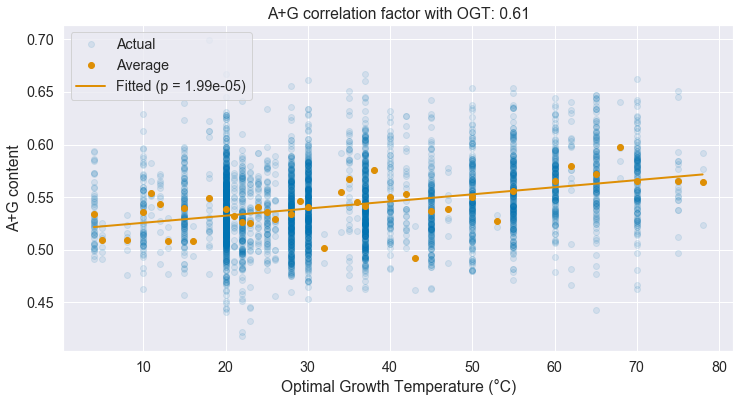

In [86]:
_, ax, y_fit, y_bins, line_params = plot_average_data_per_temperature_point(dataset_df, 'ag_content')
ax.set_ylabel('A+G content');
ax.set_title(f'A+G correlation factor with OGT: {np.corrcoef(y_bins, y_fit)[0, 1]:.2f}');

In [55]:
line_params

(0.0006757039392033613, 0.5188908611568509)

In [56]:
y_ag = (dataset_df['ag_content'].values - line_params[1]) / line_params[0]

In [59]:
np.corrcoef(y_bins, y_fit)[0, 1]

0.6135503837299475

In [58]:
np.corrcoef(y, y_ag)[0, 1]

0.2835688308929053

In [64]:
np.corrcoef(y, y_mean[:, 0])[0, 1]

0.6524500518439791

In [69]:
mae_ag = np.mean(np.abs(y_ag - y))
print(f'Mean Absolute Error (AG content): {mae_ag:.2f}')

Mean Absolute Error (AG content): 40.17


In [71]:
rmse_ag = np.sqrt(np.mean((y_ag - y) **2))
print(f'Root Mean Squared Error: {rmse_ag:.2f}')

Root Mean Squared Error: 50.79


## Plotting

In [82]:
def plot_true_vs_prediction_scatter(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    predictions_per_temp = collections.defaultdict(list)
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        predictions_per_temp[y_t].append(y_p)
        
        label = None
        if i == 0:
            label = 'Actual'
        
        ax.plot(y_t, y_p, 'o', color=palette[0], alpha=0.1, label=label)
        
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p_mean = np.mean(predictions_per_temp[y_t])
        
        label = None
        if i == 0:
            label = 'Average'
            
        ax.plot(y_t, y_p_mean, 'o', color=palette[1], label=label)
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (true value)')
    ax.set_ylabel('Temperature °C (prediction)')
    ax.legend()
    return f, ax

Text(0.5, 1.0, 'Convolutional model RMSE: 21.85 °C')

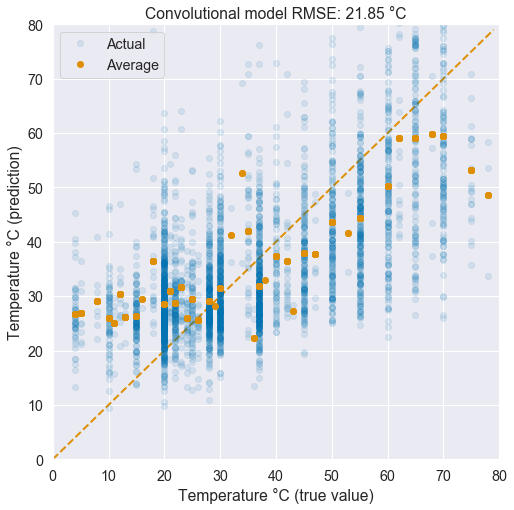

In [83]:
_, ax = plot_true_vs_prediction_scatter(y, y_mean)
ax.set_title(f'Convolutional model RMSE: {rmse:.2f} °C');

Text(0.5, 1.0, 'A+G linear model RMSE: 50.79 °C')

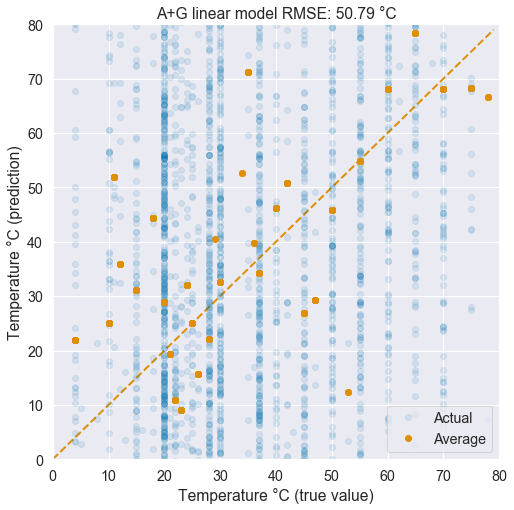

In [84]:
_, ax = plot_true_vs_prediction_scatter(y, y_ag)
ax.set_title(f'A+G linear model RMSE: {rmse_ag:.2f} °C');

In [20]:
def plot_mae_per_temperature(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    palette = sns.color_palette()
    
    error_per_temp = collections.defaultdict(list)
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        err = np.abs(y_t - y_p)
        error_per_temp[y_t].append(err)
        
        label = None
        if i == 0:
            label = 'Actual'
        
        ax.plot(y_t, err, 'o', color=palette[0], alpha=0.1, label=label)
        
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_err_mean = np.mean(error_per_temp[y_t])
        
        label = None
        if i == 0:
            label = 'Average'
        
        ax.plot(y_t, y_err_mean, 'o', color=palette[1], label=label)
        
    ax.set_xlabel('Temperature °C (true value)')
    ax.set_ylabel('Absolute error (°C)')
    ax.legend()
    
    return f, ax

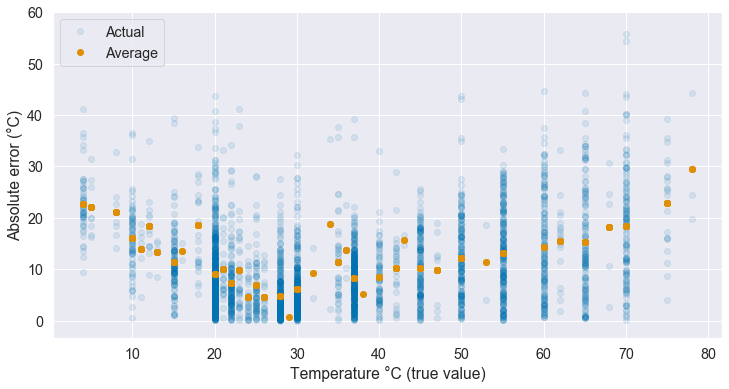

In [21]:
f, ax = plot_mae_per_temperature(y, y_mean)
ax.set_ylim(None, 60);

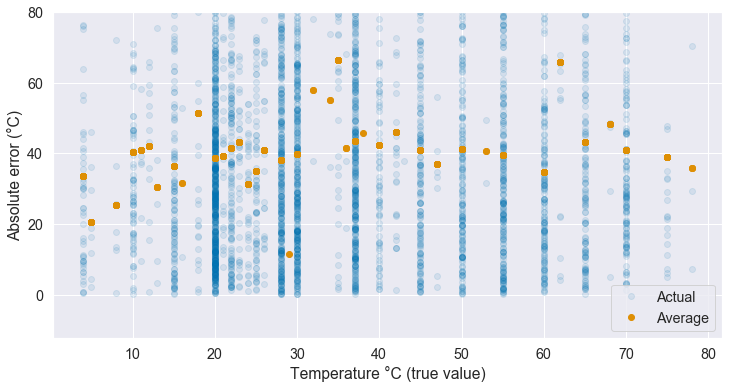

In [66]:
f, ax = plot_mae_per_temperature(y, y_ag)
ax.set_ylim(None, 80);

In [22]:
def plot_std_per_temperature(y_true, y_std):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    palette = sns.color_palette()
    
    std_per_temp = collections.defaultdict(list)
    for i in range(len(y_true)):
        y_t = y_true[i]
        std_per_temp[y_t].append(y_std[i])
        
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_std_mean = np.mean(std_per_temp[y_t])
        
        ax.plot(y_t, y_std_mean, 'o', color=palette[0])
        
    ax.set_xlabel('Temperature °C (true value)')
    ax.set_ylabel('Average standard deviation (°C)')
    
    return f, ax

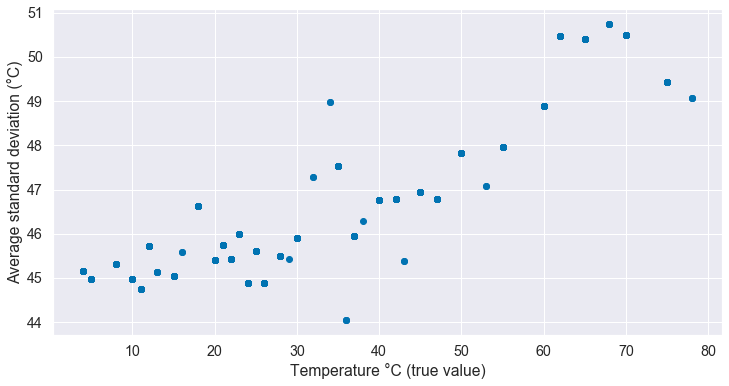

In [23]:
plot_std_per_temperature(y, y_std);

In [24]:
def mae_per_gene(dataset_df, y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(6, 12))
    palette = sns.color_palette()
    
    genes = np.array(sorted(dataset_df['gene_name'].unique().tolist()))
    
    results = []
    for i, gene in enumerate(genes):
        df = dataset_df[dataset_df['gene_name'] == gene]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    sorted_idx = np.argsort([np.sum(r) for r in results]).tolist()
    
    cm = pd.DataFrame(
        np.array(results)[sorted_idx], 
        index=[f'{g}' for i, g in enumerate(genes[sorted_idx])],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_title('Mean average error (°C)')

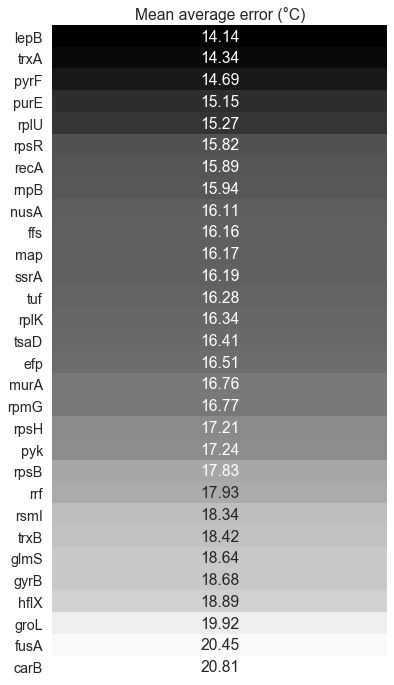

In [25]:
mae_per_gene(dataset_df, y, y_mean)

In [26]:
def mae_per_temperature_band(dataset_df, y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(6, 10))
    palette = sns.color_palette()
    
    bucket_size = 5
    bucket_starts = list(range(2, 76, bucket_size))
    temp_buckets = [f'{s}-{s + (bucket_size - 1)} °C' for s in bucket_starts]
    
    results = []
    for i, bucket_start in enumerate(bucket_starts):
        df = dataset_df[
            (dataset_df['temperature'] >= bucket_start) &
            (dataset_df['temperature'] < bucket_start + bucket_size)
        ]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    cm = pd.DataFrame(
        np.array(results), 
        index=[f'{g}' for i, g in enumerate(temp_buckets)],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax, linewidths=1, linecolor='#cccccc');
    plt.yticks(rotation=0)
    ax.set_title('MAE per temperature band')

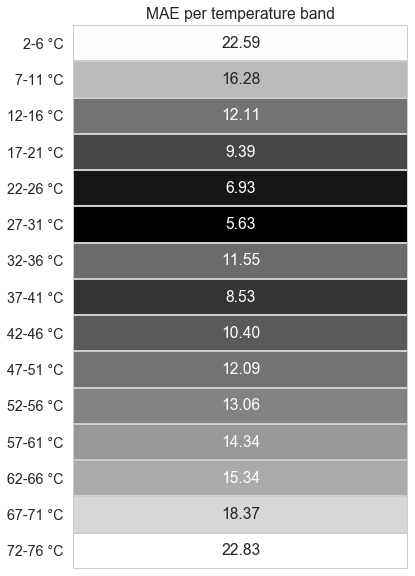

In [27]:
mae_per_temperature_band(dataset_df, y, y_mean)